**DWT QUALITY ANALYSIS**

In [1]:
from google.colab import files
import cv2
from skimage.metrics import structural_similarity as ssim

In [2]:
uploaded = files.upload()

uploaded_files = list(uploaded.keys())
cover_path = uploaded_files[0]
dwt_watermarked_path = uploaded_files[1]

cover = cv2.imread(cover_path)
dwt_watermarked = cv2.imread(dwt_watermarked_path)

if cover is None or dwt_watermarked is None:
    raise FileNotFoundError("Check that the uploaded images are valid!")

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img

psnr_dwt = cv2.PSNR(cover, dwt_watermarked)
ssim_dwt = ssim(to_gray(cover), to_gray(dwt_watermarked))

print(f"DWT Watermarking -> PSNR: {psnr_dwt:.2f} dB, SSIM: {ssim_dwt:.4f}")


Saving cover.jpeg to cover.jpeg
Saving watermarked.png to watermarked.png
DWT Watermarking -> PSNR: 21.75 dB, SSIM: 0.7071


**DCT QUALITY ANALYSIS**

In [3]:
!pip install scikit-image

import cv2
from skimage.metrics import structural_similarity as ssim
from google.colab import files

# Upload images
uploaded = files.upload()

# Get uploaded filenames
uploaded_files = list(uploaded.keys())
cover_path = uploaded_files[0]
dct_watermarked_path = uploaded_files[1]

# Read images
cover = cv2.imread(cover_path)
dct_watermarked = cv2.imread(dct_watermarked_path)

if cover is None or dct_watermarked is None:
    raise FileNotFoundError("Uploaded images could not be read. Make sure they are valid image files!")

# Convert to grayscale for SSIM
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img

# Compute PSNR and SSIM
psnr_dct = cv2.PSNR(cover, dct_watermarked)
ssim_dct = ssim(to_gray(cover), to_gray(dct_watermarked))

print(f"DCT Watermarking -> PSNR: {psnr_dct:.2f} dB, SSIM: {ssim_dct:.4f}")


Saving cover2.jpg to cover2.jpg
Saving watermarked2.jpg to watermarked2.jpg
DCT Watermarking -> PSNR: 31.62 dB, SSIM: 0.9599


**HYBRID QUALITY ANALYSIS**

In [5]:
import cv2
import numpy as np
import pywt
from skimage.metrics import structural_similarity as ssim

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def hybrid_dwt_dct_embed_color(cover_path, watermark_path, output_path, alpha=0.1):
    cover = cv2.imread(cover_path)
    watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
    if cover is None or watermark is None:
        raise FileNotFoundError("Check your image paths!")

    cover = cv2.resize(cover, (512, 512))
    watermark = cv2.resize(watermark, (128, 128))

    ycrcb = cv2.cvtColor(cover, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)

    LL, (LH, HL, HH) = pywt.dwt2(np.float32(Y), 'haar')
    dct_LL = cv2.dct(LL)
    watermark_norm = np.float32(watermark) / 255.0
    dct_LL[0:128, 0:128] += alpha * watermark_norm
    LL_new = cv2.idct(dct_LL)
    Y_new = pywt.idwt2((LL_new, (LH, HL, HH)), 'haar')
    Y_new = np.clip(Y_new, 0, 255).astype(np.uint8)

    watermarked_ycrcb = cv2.merge((Y_new, Cr, Cb))
    watermarked_bgr = cv2.cvtColor(watermarked_ycrcb, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(output_path, watermarked_bgr)

    print(f"Watermark embedded successfully → {output_path}")

    # ---- PSNR & SSIM evaluation ----
    watermarked = cv2.imread(output_path)
    psnr_hybrid = cv2.PSNR(cover, watermarked)
    ssim_hybrid = ssim(to_gray(cover), to_gray(watermarked))

    print(f"Hybrid Watermarking -> PSNR: {psnr_hybrid:.2f} dB, SSIM: {ssim_hybrid:.4f}")

if __name__ == "__main__":
    hybrid_dwt_dct_embed_color(
        cover_path="cover.jpeg",
        watermark_path="logo.png",
        output_path="watermarked.png",
        alpha=0.1
    )


Watermark embedded successfully → watermarked.png
Hybrid Watermarking -> PSNR: 49.66 dB, SSIM: 0.9974


**DWT AND DCT AND HYBRID QUALITY ANALYSIS COMPARISON**


Quality Comparison Table:

  Algorithm  PSNR (dB)    SSIM
0       DWT      21.75  0.7071
1       DCT      31.62  0.9599
2    Hybrid      49.76  0.9995


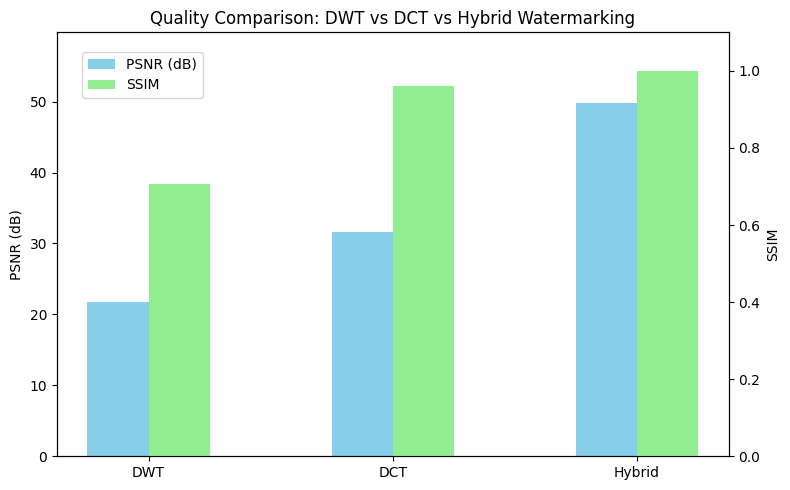

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

algorithms = ['DWT', 'DCT', 'Hybrid']
psnr_values = [21.75, 31.62, 49.76]
ssim_values = [0.7071, 0.9599, 0.9995]

df = pd.DataFrame({
    'Algorithm': algorithms,
    'PSNR (dB)': psnr_values,
    'SSIM': ssim_values
})
print("Quality Comparison Table:\n")
print(df)

fig, ax1 = plt.subplots(figsize=(8,5))

bar_width = 0.25
x = range(len(algorithms))

ax1.bar(x, psnr_values, width=bar_width, label='PSNR (dB)', color='skyblue')
ax1.set_ylabel('PSNR (dB)')
ax1.set_xticks([i + bar_width/2 for i in x])
ax1.set_xticklabels(algorithms)
ax1.set_ylim(0, max(psnr_values)+10)

ax2 = ax1.twinx()
ax2.bar([i + bar_width for i in x], ssim_values, width=bar_width, label='SSIM', color='lightgreen')
ax2.set_ylabel('SSIM')
ax2.set_ylim(0, 1.1)

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Quality Comparison: DWT vs DCT vs Hybrid Watermarking')
plt.tight_layout()
plt.show()
